# _Common statistical tests are linear models_: Python port

Original post by Jonas Kristoffer Lindeløv ([blog](https://lindeloev.net), [profile](http://personprofil.aau.dk/117060)). Python port by George Ho ([blog](https://eigenfoo.xyz)).

> This is a Python port of Jonas Kristoffer Lindeløv's post [_Common statistical tests are linear models (or: how to teach stats_)](https://lindeloev.github.io/tests-as-linear/), which originally had accompanying code in R.
>
> View this notebook [on GitHub](https://github.com/eigenfoo/tests-as-linear). Launch this notebook [on Binder](https://gke.mybinder.org/v2/gh/eigenfoo/tests-as-linear/master?filepath=tests-as-linear.ipynb).

In [1]:
from datetime import datetime
from IPython.display import display, Markdown
from tests_as_linear.utils import generate_toc
display(Markdown("Last updated: {}".format(datetime.now().strftime("%B %d, %Y"))))
display(Markdown(generate_toc()))

Last updated: February 01, 2024

# Contents
- [_Common statistical tests are linear models_: Python port](#_Common-statistical-tests-are-linear-models_:-Python-port)
- [1 The simplicity underlying common tests](#1-The-simplicity-underlying-common-tests)
- [2 Python environment](#2-Python-environment)
- [3 Pearson and Spearman correlation](#3-Pearson-and-Spearman-correlation)
- [4 One mean](#4-One-mean)
  - [4.1 One sample t-test and Wilcoxon signed-rank](#4.1-One-sample-t-test-and-Wilcoxon-signed-rank)
  - [4.2 Paired samples t-test and Wilcoxon matched pairs](#4.2-Paired-samples-t-test-and-Wilcoxon-matched-pairs)
- [5 Two means](#5-Two-means)
  - [5.1 Independent t-test and Mann-Whitney U](#5.1-Independent-t-test-and-Mann-Whitney-U)
  - [5.2 Welch’s t-test](#5.2-Welch’s-t-test)
- [6 Three or more means](#6-Three-or-more-means)
  - [6.1 One-way ANOVA and Kruskal-Wallis](#6.1-One-way-ANOVA-and-Kruskal-Wallis)
  - [6.2 Two-way ANOVA](#6.2-Two-way-ANOVA)
- [7 Proportions: Chi-square is a log-linear model](#7-Proportions:-Chi-square-is-a-log-linear-model)
  - [7.1 Goodness of fit](#7.1-Goodness-of-fit)
  - [7.2 Contingency tables](#7.2-Contingency-tables)
- [8 Sources and further equivalences](#8-Sources-and-further-equivalences)
- [9 Teaching materials and a course outline](#9-Teaching-materials-and-a-course-outline)
- [10 Limitations](#10-Limitations)
- [11 License](#11-License)

This document is summarised in the table below. It shows the linear models underlying common parametric and "non-parametric" tests. Formulating all the tests in the same language highlights the many similarities between them. Get it [as an image](cheatsheets/linear_tests_cheat_sheet.png) or [as a PDF](cheatsheets/linear_tests_cheat_sheet.pdf).

---

[![Cheatsheet](cheatsheets/linear_tests_cheat_sheet.png)](cheatsheets/linear_tests_cheat_sheet.pdf)

---

# 1 The simplicity underlying common tests

Most of the common statistical models (t-test, correlation, ANOVA, chi-square, etc.) are special cases of linear models, or a very close approximation. This beautiful simplicity means that there is less to learn. In particular, it all comes down to $y = a \cdot x + b$ which most students know from high school. Unfortunately, introductory statistics courses are usually taught as if each test is an independent tool, needlessly making life more complicated for students and teachers alike. 

This needless complexity multiplies when students try to rote learn the parametric assumptions underlying each test separately rather than deducing them from the linear model.

For this reason, I think that teaching linear models first and foremost and *then* name-dropping the special cases along the way makes for an excellent teaching strategy, emphasizing *understanding* over rote learning. Since linear models are the same across frequentist, Bayesian, and permutation-based inferences, I'd argue that it's better to start with modeling than p-values, type-1 errors, Bayes factors, or other inferences.

Concerning the teaching of *"non-parametric"* tests in intro-courses, I think that we can justify [lying-to-children](https://en.wikipedia.org/wiki/Lie-to-children) and teach "non-parametric"" tests as if they are merely ranked versions of the corresponding parametric tests. It is much better for students to think "ranks!" than to believe that you can magically throw away assumptions. Indeed, the Bayesian equivalents of "non-parametric"" tests implemented in [JASP](https://jasp-stats.org) [literally just do (latent) ranking](https://arxiv.org/abs/1712.06941) and that's it. For the frequentist "non-parametric" tests considered here, this approach is highly accurate for N > 15.

Use the table of contents (above) to jump to your favourite section. There are links to lots of similar (though more scattered) stuff under [sources](#links) and [teaching materials](#course). I hope that you will join in suggesting improvements or submitting improvements yourself in [the Github repo for this page](https://github.com/eigenfoo/tests-as-linear) or [the repo for the original post (in R)](https://github.com/lindeloev/tests-as-linear). Let's make it awesome!

# 2 Python environment

In [2]:
!cat requirements.txt

jupyter==1.0.0
jupyterlab==3.2.1
matplotlib==3.4.3
numpy==1.21.3
pandas==1.3.4
patsy==0.5.2
scipy==1.7.1
statsmodels==0.13.0


In [3]:
# plt.style.available

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
# See GitHub repo for supporting Python code.
from tests_as_linear import plots, utils

np.random.seed(1618)

# 3 Pearson and Spearman correlation

### 3.0.1 Theory: As linear models 

**Model:** the recipe for $y$ is a slope ($\beta_1$) times $x$ plus an intercept ($\beta_0$, aka a straight line).

$y = \beta_0 + \beta_1 x \qquad \mathcal{H}_0: \beta_1 = 0$

... which is a math-y way of writing the good old $y = ax + b$ (here ordered as $y = b + ax$). Using `patsy` lets us be a bit lazier and write `y ~ 1 + x` which reads like `y = 1 * number + x * othernumber`, and the task of linear models is simply to find the numbers that best predict `y`.

Either way you write it, it's an intercept ($\beta_0$) and a slope ($\beta_1$) yielding a straight line:

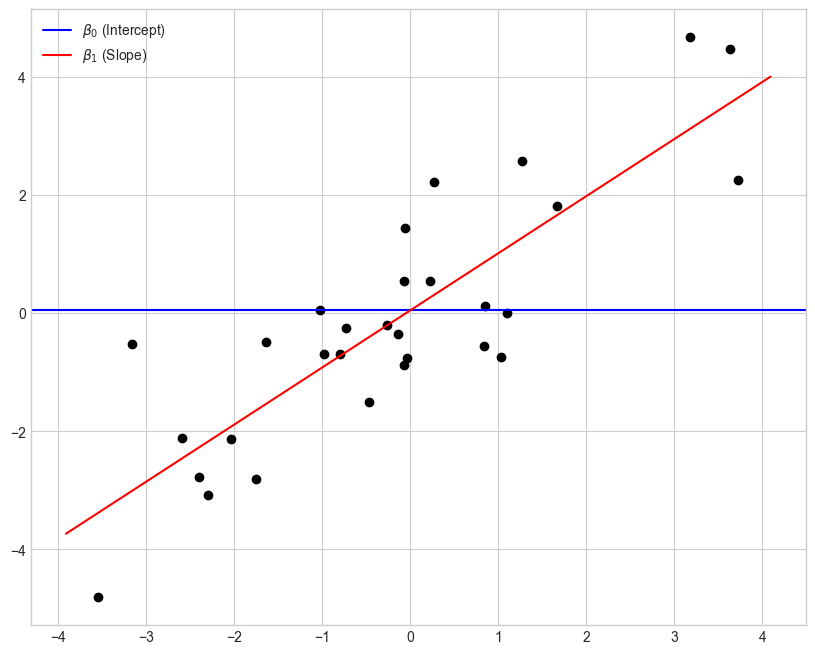

In [5]:
plots.linear_regression_plot()
plt.show()

This is often simply called a *regression* model which can be extended to *multiple regression* where there are several $\beta$s and on the right-hand side multiplied with the predictors. Everything below, from [one-sample t-test](#4.1-One-sample-t-test-and-Wilcoxon-signed-rank) to [two-way ANOVA](#6.2-Two-way-ANOVA) are just special cases of this system. Nothing more, nothing less.

As the name implies, the *Spearman rank correlation* is a *Pearson correlation* on rank-transformed $x$ and $y$:

$\text{rank}(y) = \beta_0 + \beta_1 \cdot \text{rank}(x) \qquad \mathcal{H}_0: \beta_1 = 0$

I'll introduce [ranks](#3.0.2-Theory:-rank-transformation) in a minute. For now, notice that the correlation coefficient of the linear model is identical to a "real" Pearson correlation, but p-values are an approximation which is is [appropriate for samples greater than N = 10 and almost perfect when N > 20](https://lindeloev.github.io/tests-as-linear/simulations/simulate_spearman.html).

Such a nice and non-mysterious equivalence that many students are left unaware of! Visualizing them side by side including data labels, we see this rank-transformation in action:

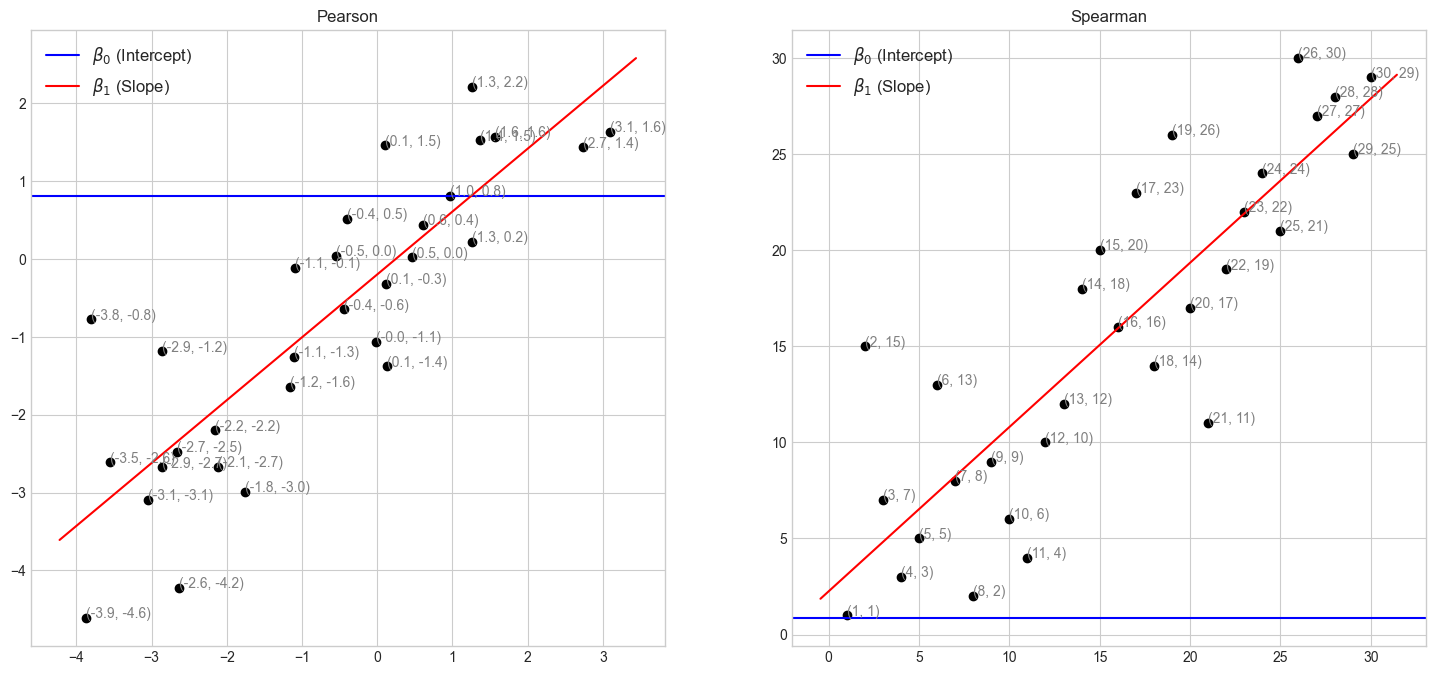

In [6]:
plots.pearson_spearman_plot()
plt.show()

### 3.0.2 Theory: rank-transformation

`scipy.stats.rankdata` simply takes an array of numbers and "replaces" them with the integers of their rank (1st smallest, 2nd smallest, 3rd smallest, etc.). `pd.DataFrame.rank` performs a similar function, but with support for `pandas.DataFrames`. So the result of the rank-transformation `scipy.stats.rankdata([3.6, 3.4, -5.0, 8.2])` is `[3, 2, 1, 4]`. See that in the figure above?

A _signed_ rank is the same, just where we rank according to absolute size first and then add in the sign second. So the signed rank here would be `[2, 1, -3, 4]`. Or in code:

In [7]:
def signed_rank(df):
    return np.sign(df) * df.abs().rank()

I hope I don't offend anyone when I say that ranks are easy; yet it's all you need to do to convert most parametric tests into their "non-parametric" counterparts! One interesting implication is that *many "non-parametric tests" are about as parametric as their parametric counterparts with means, standard deviations, homogeneity of variance, etc. - just on rank-transformed data*. That's why I put "non-parametric" in quotation marks.

### 3.0.3 Python code: Pearson correlation

It couldn't be much simpler to run these models with `statsmodels` ([`smf.ols`](https://www.statsmodels.org/stable/example_formulas.html#ols-regression-using-formulas)) or `scipy` ([`scipy.stats.pearson`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)). They yield identical slopes, `p` and `t` values, but there's a catch: `smf.ols` gives you the *slope* and even though that is usually much more interpretable and informative than the _correlation coefficient_ $r$, you may still want $r$. Luckily, the slope becomes $r$ if `x` and `y` have a standard deviation of exactly 1. You can do this by scaling the data: `data /= data.std()`.

Notice how `scipy.stats.pearsonr` and `smf.ols (scaled)` have the same slopes, $p$ and $t$ values. Also note that statistical functions from `scipy.stats` do not provide confidence intervals, while performing the linear regression with `smf.ols` does.

In [8]:
correlated = pd.DataFrame()
correlated["x"] = np.linspace(0, 1)
correlated["y"] = 1.5 * correlated.x + 2 * np.random.randn(len(correlated.x))

scaled = correlated / correlated.std()

r, p = scipy.stats.pearsonr(correlated["x"], correlated["y"])
res1 = smf.ols(formula="y ~ 1 + x", data=correlated).fit()
res2 = smf.ols(formula="y ~ 1 + x", data=scaled).fit()

In [9]:
utils.tabulate_results([r, p, None, None, None],
                       [res1, res2],
                       ["scipy.stats.pearsonr", "smf.ols", "smf.ols (scaled)"])

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.pearsonr,0.249694,0.080332,NaN,NaN,NaN
smf.ols,1.512744,0.080332,1.78652,-0.189770,3.215258
smf.ols (scaled),0.249694,0.080332,1.78652,-0.031324,0.530712


### 3.0.4 Python code: Spearman correlation

Note that we can interpret the slope which is the number of ranks $y$ change for each rank on $x$. I think that this is a pretty interesting number. However, the intercept is less interpretable since it lies at $\text{rank}(x) = 0$ which is impossible since x starts at 1.

In [10]:
ranked = np.argsort(correlated, axis=0)

r, p = scipy.stats.spearmanr(ranked["x"], ranked["y"])
res = smf.ols(formula="y ~ 1 + x", data=ranked).fit()

In [11]:
utils.tabulate_results([r, p, None, None, None],
                       res,
                       ["scipy.stats.spearmanr", "smf.ols (ranked)"])

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.spearmanr,0.233421,0.102803,NaN,NaN,NaN
smf.ols (ranked),0.233421,0.102803,1.663134,-0.048772,0.515615


# 4 One mean

## 4.1 One sample t-test and Wilcoxon signed-rank

### 4.1.1 Theory: As linear models

**t-test** model: A single number predicts $y$.

$y = \beta_0 \qquad \mathcal{H}_0: \beta_0 = 0$

In other words, it's our good old $y = \beta_0 + \beta_1*x$ where the last term is gone since there is no $x$ (essentially $x=0$, see left figure below).

The same is to a very close approximately true for **Wilcoxon signed-rank test**, just with the [signed ranks](#3.0.2-Theory:-rank-transformation) of $y$ instead of $y$ itself (see right panel below).

$\text{signed_rank}(y) = \beta_0$

[This approximation is good enough when the sample size is larger than 14 and almost perfect if the sample size is larger than 50](https://lindeloev.github.io/tests-as-linear/simulations/simulate_wilcoxon.html).

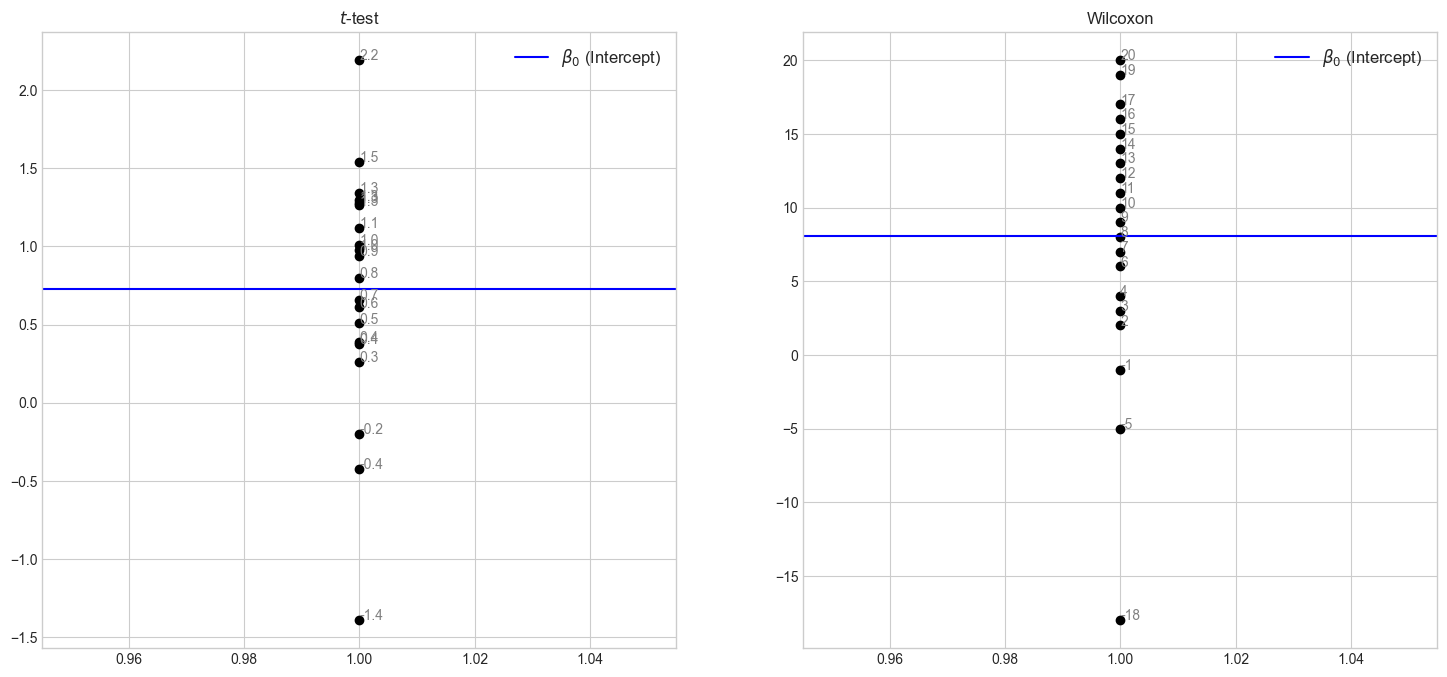

In [12]:
plots.ttest_wilcoxon_plot()
plt.show()

### 4.1.2 Example data

In [13]:
data = pd.DataFrame()
data["x"] = np.random.normal(loc=0.0, scale=1.0, size=50)  # Used in correlation where this is on x-axis
data["y"] = np.random.normal(loc=0.5, scale=1.0, size=50)  # Almost zero mean
data["y2"] = np.random.normal(loc=0.8, scale=1.0, size=50)  # Used in two means
data["y_sub_y2"] = data["y"] - data["y2"]

data.head()

,x,y,y2,y_sub_y2
0,0.767785,1.064062,-0.577012,1.641074
1,2.057987,0.097191,-3.181132,3.278323
2,-0.217646,0.631879,0.168813,0.463066
3,0.562267,0.285328,-0.667796,0.953124
4,0.125368,1.973527,2.138589,-0.165062


### 4.1.3 Python code: One-sample t-test

Try running the Python code below and see that the linear model (`smf.ols`) produces the same $t$, $p$, and $r$ as `scipy.stats.ttest_1samp`. The confidence interval is not computed by `scipy` but would theoretically also be identical:

In [14]:
t, p = scipy.stats.ttest_1samp(data.y, 0)
res = smf.ols(formula="y ~ 1", data=data).fit()  # Equivalent linear model: intercept-only

In [15]:
utils.tabulate_results([None, p, t, None, None],
                       res,
                       ["scipy.stats.ttest_1samp", "smf.ols (y ~ 1)"],
                       coeff="Intercept")

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.ttest_1samp,NaN,0.034067,2.180309,NaN,NaN
smf.ols (y ~ 1),0.309537,0.034067,2.180309,0.024239,0.594834


### 4.1.4 Python code: Wilcoxon signed-rank test

In [16]:
signed_rank_data = signed_rank(data)

_, p = scipy.stats.wilcoxon(data.y)
res = smf.ols("y ~ 1", data=signed_rank_data).fit()

In [17]:
utils.tabulate_results([None, p, None, None, None],
                       res,
                       ["scipy.stats.wilcoxon", "smf.ols (y ~ 1, signed rank)"],
                       coeff="Intercept")

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.wilcoxon,NaN,0.033688,NaN,NaN,NaN
"smf.ols (y ~ 1, signed rank)",8.78,0.032656,2.198632,0.754979,16.805021


## 4.2 Paired samples t-test and Wilcoxon matched pairs

### 4.2.1 Theory: As linear models

**t-test** model: a single number (intercept) predicts the pairwise differences.

$y_2-y_1 = \beta_0 \qquad \mathcal{H}_0: \beta_0 = 0$

This means that there is just one $y = y_2 - y_1$ to predict and it becomes a [one-sample t-test](#4.1-One-sample-t-test-and-Wilcoxon-signed-rank) on the pairwise differences. The visualization is therefore also the same as for the one-sample t-test. At the risk of overcomplicating a simple substraction, you can think of these pairwise differences as slopes (see left panel of the figure), which we can represent as y-offsets (see right panel of the figure):

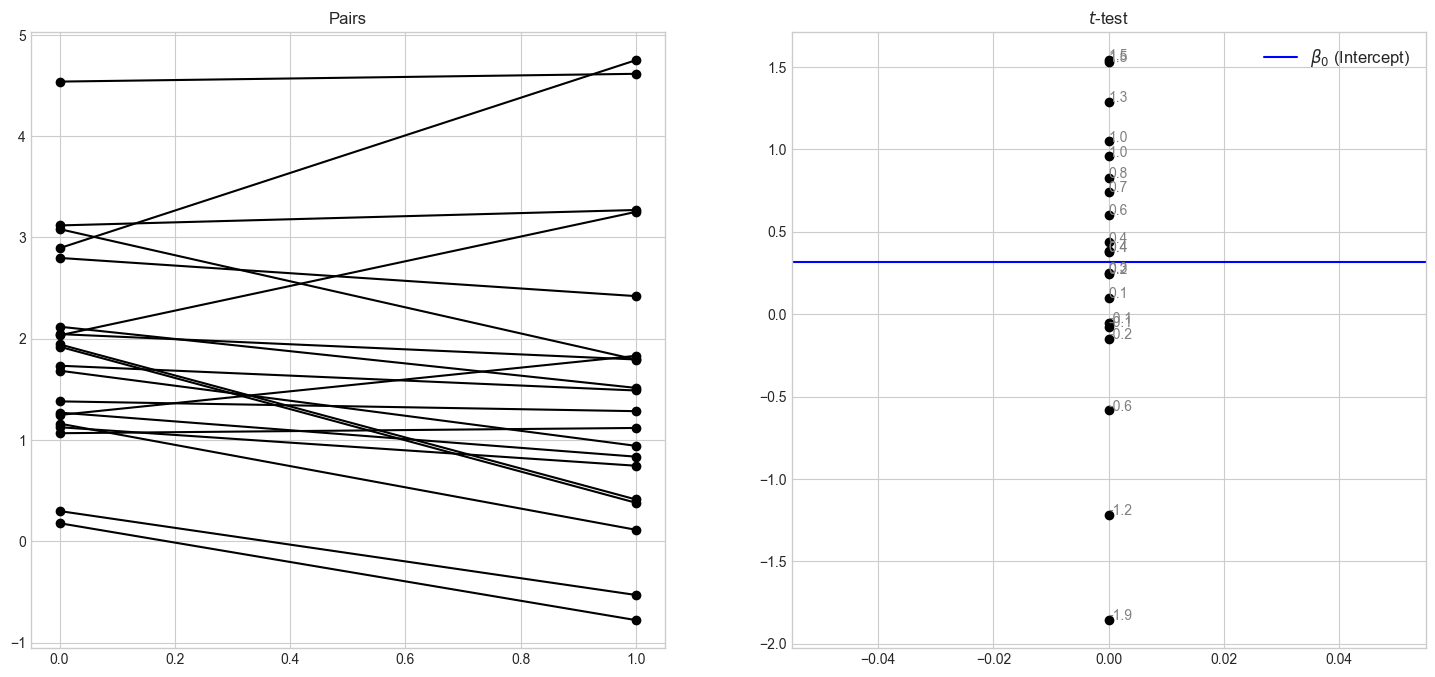

In [18]:
plots.pairs_wilcoxon_plot()
plt.show()

Similarly, the **Wilcoxon matched pairs** only differ from **Wilcoxon signed-rank** in that it's testing the signed ranks of the pairwise $y_2-y_1$ differences.

$\textrm{signed\_rank}(y_2-y_1) = \beta_0 \qquad \mathcal{H}_0: \beta_0 = 0$

### 4.2.2 Python code: Paired sample t-test

In [19]:
t, p = scipy.stats.ttest_rel(data.y, data.y2)
res = smf.ols(formula="y_sub_y2 ~ 1", data=data).fit()

In [20]:
utils.tabulate_results([None, p, t, None, None],
                       res,
                       ["scipy.stats.ttest_rel", "smf.ols (y_sub_y2 ~ 1)"],
                       coeff="Intercept")

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.ttest_rel,NaN,0.174559,-1.377691,NaN,NaN
smf.ols (y_sub_y2 ~ 1),-0.371131,0.174559,-1.377691,-0.912482,0.170221


### 4.2.3 Python code: Wilcoxon matched pairs

Again, we do the signed-ranks trick. This is still an approximation, but a close one:

In [21]:
_, p = scipy.stats.wilcoxon(data.y, data.y2)
res = smf.ols(formula="y_sub_y2 ~ 1", data=signed_rank_data).fit()

In [22]:
utils.tabulate_results([None, p, None, None, None],
                       res,
                       ["scipy.stats.wilcoxon", "smf.ols (y_sub_y2 ~ 1, signed rank)"],
                       coeff="Intercept")

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.wilcoxon,NaN,0.218662,NaN,NaN,NaN
"smf.ols (y_sub_y2 ~ 1, signed rank)",-5.14,0.218208,-1.247322,-13.421116,3.141116


For large sample sizes (N >> 100), this approaches the **sign test** to a reasonable degree, but this approximation is too inaccurate to flesh out here.

# 5 Two means

## 5.1 Independent t-test and Mann-Whitney U

### 5.1.1 Theory: As linear models

**Independent t-test model:** two means predict $y$.

$y_i = \beta_0 + \beta_1 x_i \qquad \mathcal{H}_0: \beta_1 = 0$

where $x_i$ is an indicator (0 or 1) saying whether data point $i$ was sampled from one or the other group. [Indicator variables (also called "dummy coding")](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) underly a lot of linear models and we'll take an aside to see how it works in a minute.

**Mann-Whitney U** (also known as **Wilcoxon rank-sum test** for two independent groups; no *signed* rank this time) is the same model to a very close approximation, just on the ranks of $x$ and $y$ instead of the actual values:

$\text{rank}(y_i) = \beta_0 + \beta_1 x_i \qquad \mathcal{H}_0: \beta_1 = 0$

To me, equivalences like this make "non-parametric" statistics much easier to understand. The approximation is appropriate [when the sample size is larger than 11 in each group and virtually perfect when N > 30 in each group](https://lindeloev.github.io/tests-as-linear/simulations/simulate_mannwhitney.html).

### 5.1.2 Theory: Dummy coding

Dummy coding can be understood visually. The indicator is on the x-axis so data points from the first group are located at $x = 0$ and data points from the second group is located at $x = 1$. Then $\beta_0$ is the intercept (blue line) and $\beta_1$ is the slope between the two means (red line). Why? Because when $\Delta x = 1$ the slope equals the difference because:

$\text{slope} = \Delta y / \Delta x = \Delta y / 1 = \Delta y = \text{difference}$

Magic! Even categorical differences can be modelled using linear models! It's a true Swiss army knife.

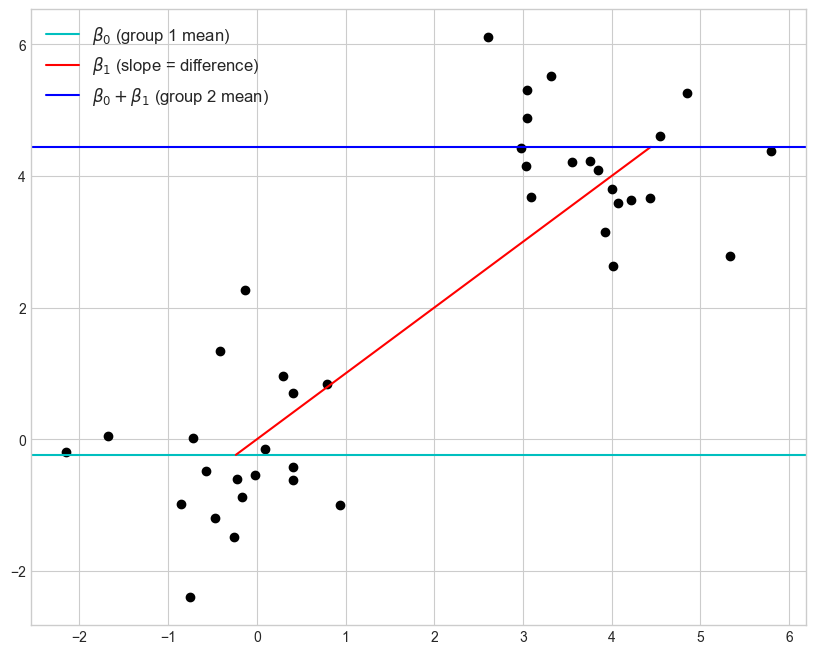

In [23]:
plots.dummy_coding_plot()
plt.show()

### 5.1.3 Theory: Dummy coding (continued)

If you feel like you get dummy coding now, just skip ahead to the next section. Here is a more elaborate explanation of dummy coding:

If a data point was sampled from the first group, i.e., when $x_i = 0$, the model simply becomes $y = \beta_0 + \beta_1 \cdot 0 = \beta_0$. In other words, the model predicts that that data point is $\beta_0$. It turns out that the $\beta$ which best predicts a set of data points is the *mean* of those data points, so $\beta_0$ is the mean of group 1.

On the other hand, data points sampled from the second group would have $x_i = 1$ so the model becomes $y_i = \beta_0 + \beta_1\cdot 1 = \beta_0 + \beta_1$. In other words, we add $\beta_1$ to "shift" from the mean of the first group to the mean of the second group. Thus $\beta_1$ becomes the *mean difference* between the groups.

As an example, say group 1 is 25 years old ($\beta_0 = 25$) and group 2 is 28 years old ($\beta_1 = 3$), then the model for a person in group 1 is $y = 25 + 3 \cdot 0 = 25$ and the model for a person in group 2 is $y = 25 + 3 \cdot 1 = 28$. 

Hooray, it works! For first-timers it takes a few moments to understand dummy coding, but you only need to know addition and multiplication to get there!

### 5.1.4 Python code: independent t-test

As a reminder, when we write `y ~ 1 + x` with `patsy`, it is shorthand for $y = \beta_0 \cdot 1 + \beta_1 \cdot x$ and Python goes on computing the $\beta$s for you. Thus `y ~ 1 + x` is the `patsy` (and/or R) way of writing $y = a \cdot x + b$.

Notice the identical `p` estimates.

In [24]:
groups = pd.DataFrame(data=np.concatenate([data.y, data.y2]),
                      columns=["y"])
groups["group"] = np.concatenate([np.zeros_like(data.y), np.ones_like(data.y2)])
groups.head()

,y,group
0,1.064062,0.0
1,0.097191,0.0
2,0.631879,0.0
3,0.285328,0.0
4,1.973527,0.0


In [25]:
t, p = scipy.stats.ttest_ind(data.y2, data.y)
res = smf.ols("y ~ 1 + group", groups).fit()

In [26]:
utils.tabulate_results([None, p, t, None, None],
                       res,
                       ["scipy.stats.ttest_ind", "smf.ols (y ~ 1 + group)"],
                       coeff="group")

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.ttest_ind,NaN,0.123488,1.553663,NaN,NaN
smf.ols (y ~ 1 + group),0.371131,0.123488,1.553663,-0.102908,0.845169


### 5.1.5 Python code: Mann-Whitney U

In [27]:
groups['yranks'] = groups.y.rank()  # (unsigned) ranks of y values

_, p = scipy.stats.mannwhitneyu(data.y, data.y2)
res = smf.ols("yranks ~ 1 + group", groups).fit()

In [28]:
utils.tabulate_results([None, p, None, None, None],
                       res,
                       ["scipy.stats.mannwhitneyu", "smf.ols (yranks ~ 1 + group)"],
                       coeff="group")

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.mannwhitneyu,NaN,0.103019,NaN,NaN,NaN
smf.ols (yranks ~ 1 + group),9.48,0.102569,1.647932,-1.935977,20.895977


## 5.2 Welch’s t-test

This is similar to Student's [independent t-test](#5.1.4-Python-code:-independent-t-test) above, except that **Welch's t-test** does not assumes identical variances. We must therefore use a [generalized linear model](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.GLS.html) and set the (diagonal of the) covariance matrix `sigma` based on the sample variances. See https://stats.stackexchange.com/q/142685 for info about this in R.

In [29]:
t, p = scipy.stats.ttest_ind(data.y2, data.y, equal_var=False)
n, vary = len(data.y), data.y.var()
m, vary2 = len(data.y2), data.y2.var()
sigma = [vary]*n + [vary2]*m
res = smf.gls("y ~ 1 + group", groups, sigma=sigma).fit()

In [30]:
utils.tabulate_results([None, p, t, None, None],
                       res,
                       ["scipy.stats.ttest_ind with equal_var=False", "smf.gls (y ~ 1 + group) + sigma"],
                       coeff="group")

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.ttest_ind with equal_var=False,NaN,0.123766,1.553663,NaN,NaN
smf.gls (y ~ 1 + group) + sigma,0.371131,0.123488,1.553663,-0.102908,0.845169


# 6 Three or more means

ANOVAs are linear models with (only) categorical predictors so they simply extend everything we did above, relying heavily on dummy coding. Do make sure to read [the section on dummy coding](#5.1.2-Theory:-Dummy-coding) if you haven't already.

## 6.1 One-way ANOVA and Kruskal-Wallis

### 6.1.1 Theory: As linear models

Model: One mean for each group predicts $y$.

$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 +... \qquad \mathcal{H}_0: y = \beta_0$

where $x_i$ are indicators ($x=0$ or $x=1$) where at most one $x_i=1$ while all others are $x_i=0$. 

Notice how this is just "more of the same" of what we already did in other models above. When there are only two groups, this model is $y = \beta_0 + \beta_1*x$, i.e. the [independent t-test](#5.1-Independent-t-test-and-Mann-Whitney-U). If there is only one group, it is $y = \beta_0$, i.e. the [one-sample t-test](#4.1-One-sample-t-test-and-Wilcoxon-signed-rank). This is easy to see in the visualization below - just cover up a few groups and see that it matches the other visualizations above.

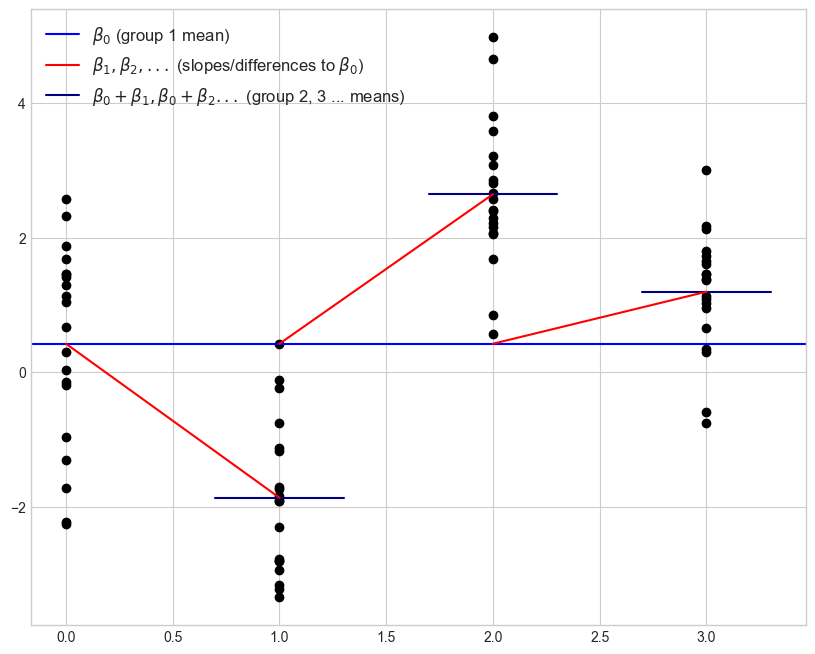

In [31]:
plots.one_way_anova_plot()
plt.show()

A one-way ANOVA has a log-linear counterpart called [goodness-of-fit](#7.1-Goodness-of-fit) test which we'll return to. By the way, since we now regress on more than one $x$, the one-way ANOVA is a **multiple regression** model.

The **Kruskal-Wallis** test is simply a **one-way ANOVA** on the rank-transformed $y$ (`value`):

$\text{rank}(y) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 +...$

This approximation is [good enough for 12 or more data points](https://lindeloev.github.io/tests-as-linear/simulations/simulate_kruskall.html). Again, if you do this for just one or two groups, we're already acquainted with those equations, i.e. the [Wilcoxon signed-rank test](#4.1-One-sample-t-test-and-Wilcoxon-signed-rank) or the [Mann-Whitney U test](#5.1-Independent-t-test-and-Mann-Whitney-U) respectively. 

### 6.1.2 Example data

We make a three-level factor with the levels `a`, `b`, and `c` so that the **one-way ANOVA** basically becomes a "three-sample t-test". Then we manually do the [dummy coding](#5.1.2-Theory:-Dummy-coding) of the groups.

In [32]:
num_points = 20

a = np.random.normal(0.0, 1, num_points)
b = np.random.normal(3.0, 1, num_points)
c = np.random.normal(-1.5, 1, num_points)

df = pd.DataFrame()
df["y"] = np.concatenate([a, b, c])
df["group"] = list("".join([num_points * char for char in "abc"]))
df = df.join(pd.get_dummies(df.group, prefix="group", drop_first=True).astype(np.float64))

df.head()

,y,group,group_b,group_c
0,0.716705,a,0.0,0.0
1,0.893515,a,0.0,0.0
2,1.225369,a,0.0,0.0
3,-1.381969,a,0.0,0.0
4,-0.387262,a,0.0,0.0


With group a's intercept omni-present, see how exactly one other parameter is added to predict `value` for group b and c in a given row. Thus data points in group b never affect the estimates in group c.

### 6.1.3 Python code: one-way ANOVA

OK, let's see the identity between `scipy`'s dedicated **ANOVA** function (`scipy.stats.f_oneway`) and the dummy-coded in-your-face linear model with `smf.ols`.

In [33]:
F, p = scipy.stats.f_oneway(a, b, c)
res = smf.ols("y ~ 1 + group_b + group_c", df).fit()

In [34]:
table = pd.DataFrame(index=["F statistic", "p value", "df"])
table["scipy.stats.f_oneway"] = [F, p, None]
table["ols (y ~ 1 + group_b + group_c)"] = [res.fvalue, res.f_pvalue, res.df_model]

table.T

,F statistic,p value,df
scipy.stats.f_oneway,99.748036,2.418983e-19,NaN
ols (y ~ 1 + group_b + group_c),99.748036,2.418983e-19,2.0


Note that [`sm.stats.anova_lm`](https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html) gives you a pretty ANOVA table with relevant statistics, if you give it the fitted `res` object. By default it computes type-I sum of squares, which is widely discouraged. There is a BIG polarized debate about whether to use type-II (by passing `typ=2`) or type-III sum of squares (`typ=3`), but let's skip that for now.

### 6.1.4 Python code: Kruskal-Wallis

In [35]:
df["yranks"] = df["y"].rank()

In [36]:
_, p = scipy.stats.kruskal(a, b, c)
res = smf.ols("yranks ~ 1 + group_b + group_c", df).fit()

In [37]:
table = pd.DataFrame(index=["p value", "df"])
table["scipy.stats.kruskal"] = [p, None]
table["ols (yranks ~ 1 + group_b + group_c)"] = [res.f_pvalue, res.df_model]

table.T

,p value,df
scipy.stats.kruskal,4.009890e-11,NaN
ols (yranks ~ 1 + group_b + group_c),2.215307e-21,2.0


## 6.2 Two-way ANOVA

### 6.2.1 Theory: As linear models

Model: one mean per group (main effects) plus these means multiplied across factors (interaction effects). The main effects are the [one-way ANOVAs](#6.1-One-way-ANOVA-and-Kruskal-Wallis) above, though in the context of a larger model. The interaction effect is harder to explain in the abstract even though it's just a few numbers multiplied with each other. I will leave that to the teachers to keep focus on equivalences here :-)

Switching to matrix notation:

$y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2 \qquad \mathcal{H}_0: \beta_3 = 0$

Here $\beta_i$ are vectors of betas of which only one is selected by the indicator vector $X_i$. The $\mathcal{H}_0$ shown here is the interaction effect. Note that the intercept $\beta_0$, to which all other $\beta$s are relative, is now the mean for the first level of all factors.

Continuing with the dataset from the one-way ANOVA above, let's add a crossing factor `mood` so that we can test the `group:mood` interaction (a 3x2 ANOVA). We also do the [dummy coding](#5.1.2-Theory:-Dummy-coding) of this factor needed for the linear model.

In [38]:
df["mood"] = (df.shape[0] // 2) * ["happy", "sad"]
df = df.join(pd.get_dummies(df.mood, prefix="mood").astype(np.float64))

df.head()

,y,group,group_b,group_c,yranks,mood,mood_happy,mood_sad
0,0.716705,a,0.0,0.0,36.0,happy,1.0,0.0
1,0.893515,a,0.0,0.0,37.0,sad,0.0,1.0
2,1.225369,a,0.0,0.0,38.0,happy,1.0,0.0
3,-1.381969,a,0.0,0.0,14.0,sad,0.0,1.0
4,-0.387262,a,0.0,0.0,24.0,happy,1.0,0.0


$\beta_0$ is now the happy guys from group a!

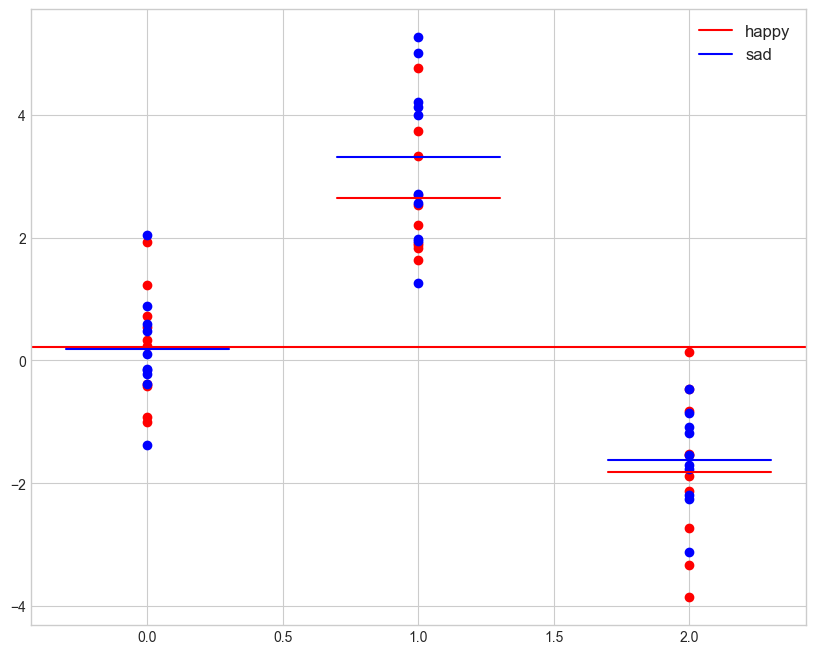

In [39]:
plots.two_way_anova_plot(df)
plt.show()

### 6.2.2 Python code: Two-way ANOVA

<div class="alert alert-warning">
    <b>Note on Python port:</b>
    Unfortunately, <code>scipy.stats</code> does not have a dedicated function to perform two-way ANOVA, so we cannot demonstrate directly that it is fundamentally a linear model. Nevertheless, we will write the code to perform the linear regression.
</div>

In [40]:
# scipy.stats does not support two-way ANOVA
res = smf.ols("y ~ 1 + group * mood", df).fit()

### 6.3 ANCOVA

This is simply ANOVA with a continuous regressor added so that it now contains continuous and (dummy-coded) categorical predictors. For example, if we continue with the [one-way ANOVA](#6.1-One-way-ANOVA-and-Kruskal-Wallis) example, we can add `age` and it is now called a **one-way ANCOVA**:

$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_3 \text{age}$

... where $x_i$ are our usual dummy-coded indicator variables. $\beta_0$ is now the mean for the first group at $\text{age}=0$. You can turn all ANOVAs into ANCOVAs this way, e.g. by adding $\beta_N \cdot \text{age}$ to our **two-way ANOVA** in the previous section. But let us go ahead with our one-way ANCOVA, starting by adding $\text{age}$ to our dataset:

In [41]:
# Update data with a continuous covariate
df["age"] = df["y"] + np.random.randn(df.shape[0])  # Correlated with y

This is best visualized using colors for groups instead of x-position. The $\beta$s are still the average $y$-offset of the data points, only now we model each group using a slope instead of an intercept. In other words, the one-way ANOVA is sort of [one-sample t-tests](#4.1-One-sample-t-test-and-Wilcoxon-signed-rank) model for each group ($y = \beta_0$) while the **one-way ANCOVA** is sort of [Pearson correlation](#3-Pearson-and-Spearman-correlation) model for each group ($y_i = \beta_0 + \beta_i + \beta_1 \text{age}$):

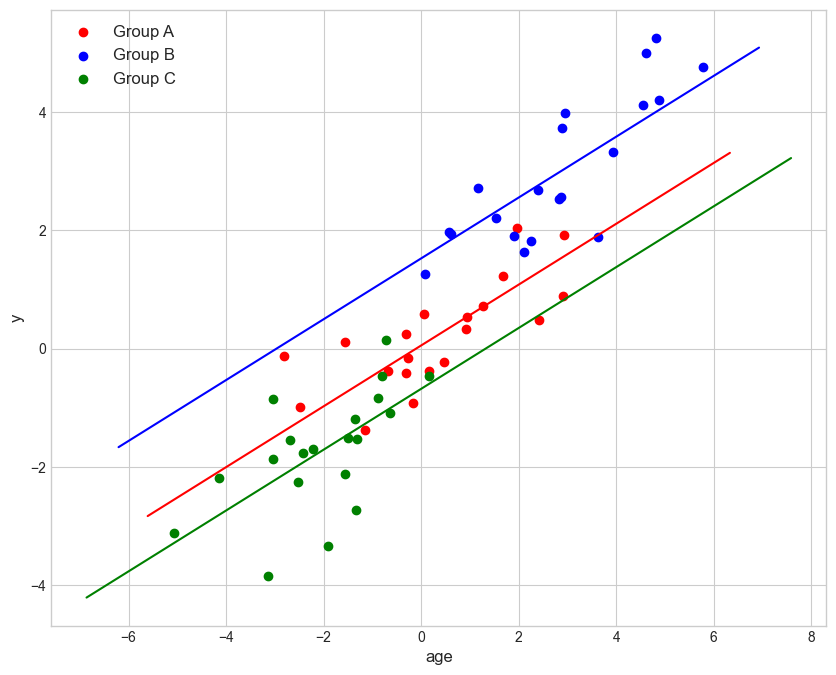

In [42]:
plots.ancova_plot(df)
plt.show()

<div class="alert alert-warning">
    <b>Note on Python port:</b>
    Unfortunately, <code>scipy.stats</code> does not have a dedicated function to perform ANCOVA, so again, we cannot demonstrate directly that it is fundamentally a linear model. Nevertheless, we will write the code to perform the linear regression.
</div>

In [43]:
res = smf.ols("y ~ 1 + group + age", df).fit()

# 7 Proportions: Chi-square is a log-linear model

Recall that when you take the logarithm, you can easily make statements about *proportions*, i.e., that for every increase in $x$, $y$ increases a certain percentage. This turns out to be one of the simplest (and therefore best!) ways to make count data and contingency tables intelligible. See [this nice introduction](https://www.uni-tuebingen.de/fileadmin/Uni_Tuebingen/SFB/SFB_833/A_Bereich/A1/Christoph_Scheepers_-_Statistikworkshop.pdf) to Chi-Square tests as linear models.


## 7.1 Goodness of fit

### 7.1.1 Theory: As log-linear model
Model: a single intercept predicts $\log(y)$.

I'll refer you to take a look at [the section on contingency tables](#contingency) which is basically a "two-way goodness of fit".


### 7.1.2 Example data

For this, we need some wide count data:

In [44]:
df = pd.DataFrame(index=["happy", "sad", "meh"])
df["counts"] = [70, 60, 90]
df = df.join(pd.get_dummies(df.index, prefix='mood', drop_first=True).set_index(df.index))

df

,counts,mood_meh,mood_sad
happy,70,0,0
sad,60,0,1
meh,90,1,0


### 7.1.3 Python code: Goodness of fit

Now let's see that the Goodness of fit is just a log-linear equivalent to a one-way ANOVA. We set `family=sm.families.Poisson()` which defaults to setting a logarithmic [link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function) (you can verify that `res.model.family.link` is a logarithm).

Note that `smf.ols` does not support GLMs: we need to use `sm.GLM`. While `sm.GLM` does not have a `patsy`-formula interface, we can still use `patsy.dmatrices` to get the [`endog` and `exog` design matrices,](https://www.statsmodels.org/stable/endog_exog.html) and then feed that into `sm.GLM`.

<div class="alert alert-warning">
    <b>Note on Python port:</b>
    Unfortunately, <code>statsmodels</code> <a href="https://stackoverflow.com/q/27328623">does not currently support performing a one-way ANOVA test on GLMs</a> (the <code>anova_lm</code> function only works for linear models), so while we can perform the GLM, there is no support for computing the F-statistic or its p-value. Nevertheless, we will write the code to perform the generalized linear regression.
</div>

In [45]:
chi2, p = scipy.stats.chisquare(df.counts)

# The `-1` is to remove the intercept term from the model
# See https://patsy.readthedocs.io/en/latest/formulas.html#intercept-handling
endog, exog = patsy.dmatrices("counts ~ 1 + mood_meh + mood_sad - 1", df)
res = sm.GLM(endog, exog, family=sm.families.Poisson()).fit()

## 7.2 Contingency tables

### 7.2.1 Theory: As log-linear model

The theory here will be a bit more convoluted, and I mainly write it up so that you can get the *feeling* that it really is just a log-linear [two-way ANOVA model](#6.2-Two-way-ANOVA). Let's get started...

For a two-way contingency table, the model of the count variable $y$ is a modeled using the marginal proportions of a contingency table. Why this makes sense, is too involved to go into here, but [see the relevant slides by Christoph Scheepers here](https://www.uni-tuebingen.de/fileadmin/Uni_Tuebingen/SFB/SFB_833/A_Bereich/A1/Christoph_Scheepers_-_Statistikworkshop.pdf) for an excellent exposition. The model is composed of a lot of counts and the regression coefficients $A_i$ and $B_j$:

$$n_{ij} = N \cdot A_i \frac{n_i}{N} \cdot B_j \frac{n_j}{N} \cdot \frac{n_{ij} N}{n_i n_j}$$

What a mess!!! Here, $i$ is the row index, $j$ is the column index, $n_{\text{something}}$ is the sum of that row and/or column, $N = \sum_{i, j}{n_{ij}}$. Remember that $n$ is a count variable, so $N$ is just the total count.

We can simplify the notation by defining the *proportions*: $\alpha_i = A_i \frac{n_i}{N}$, $\beta_i = B_j \frac{n_j}{N}$ and $\alpha\beta_{ij} = \frac{n_{ij} N}{n_i n_j}$. Let's write the model again:

$$n_{ij} = N \cdot \alpha_i \cdot \beta_j \cdot \alpha\beta_{ij}$$

Ah, much prettier. However, there is still lot's of multiplication which makes it hard to get an intuition about how the actual numbers interact. We can make it much more intelligible when we remember that $\log(A \cdot B) = \log(A) + \log(B)$. Doing logarithms on both sides, we get:

$$\log(n_{ij}) = \log(N) + \log(\alpha_i) + \log(\beta_j) + \log(\alpha\beta_{ij})$$

Snuggly! Now we can get a better grasp on how the regression coefficients (which are proportions) independently contribute to $y$. This is why logarithms are so nice for proportions. Note that this is just [the two-way ANOVA model](#anova2) with some logarithms added, so we are back to our good old linear models - only the interpretation of the regression coefficients have changed! And we cannot use `smf.ols` anymore in `statsmodels`.

### 7.2.2 Example data

Here we need some long data and we need it in table format for `chisq.test`:

In [46]:
df = pd.DataFrame(data=[[100, 70], [30, 32], [110, 120]],
                  columns=["male", "female"],
                  index=["happy", "sad", "meh"])
df.index.name = "mood"
df.columns.name = "sex"
df = df.reset_index().melt(id_vars=["mood"])
df = df.join(pd.get_dummies(df.mood, prefix="mood", drop_first=True))
df = df.join(pd.get_dummies(df.sex, prefix="sex", drop_first=True))

df

,mood,sex,value,mood_meh,mood_sad,sex_male
0,happy,male,100,0,0,1
1,sad,male,30,0,1,1
2,meh,male,110,1,0,1
3,happy,female,70,0,0,0
4,sad,female,32,0,1,0
5,meh,female,120,1,0,0


### 7.2.3 Python code: Chi-square test

Now let's show the equivalence between a chi-square model and a log-linear model. This is very similar to our [two-way ANOVA](#6.2-Two-way-ANOVA) above:

<div class="alert alert-warning">
    <b>Note on Python port:</b>
    Unfortunately, <code>statsmodels</code> <a href="https://stackoverflow.com/q/27328623">does not currently support performing a two-way ANOVA test on GLMs</a> (the <code>anova_lm</code> function only works for linear models), so while we can perform the GLM, there is no support for computing the F-statistic or its p-value. Nevertheless, we'll go through the motions of performing the generalized linear regression.
</div>

In [47]:
chi2, p, dof, _ = scipy.stats.chi2_contingency(df.value)

endog, exog = patsy.dmatrices("value ~ 1 + mood_meh*sex_male + mood_sad*sex_male - 1", df)
res = sm.GLM(endog, exog, family=sm.families.Poisson()).fit()

# 8 Sources and further equivalences

Here are links to other sources who have exposed bits and pieces of this puzzle, including many further equivalences not covered here:

 * [My original exposition of the idea](https://stats.stackexchange.com/questions/303269/common-statistical-tests-as-linear-models) at Cross Validated
 * [An earlier question by me](https://stats.stackexchange.com/questions/210529/are-parametric-tests-on-rank-transformed-data-equivalent-to-non-parametric-test?noredirect=1#comment399981_210529) about non-parametric tests and a helpful answer.
 * [This question and replies](https://stats.stackexchange.com/questions/59047/how-are-regression-the-t-test-and-the-anova-all-versions-of-the-general-linear) on t-tests and ANOVA at StackOverflow
 * [These slides by Christoph Scheepers](https://www.uni-tuebingen.de/fileadmin/Uni_Tuebingen/SFB/SFB_833/A_Bereich/A1/Christoph_Scheepers_-_Statistikworkshop.pdf) on Chi-Square as log-linear models.
 * [This notebook by Philip M. Alday](https://rpubs.com/palday/glm-test) on Chi-square, binomial, multinomial, and poisson tests as log-linear and logistic models. These "equivalences" are less exact than what I presented above, and were therefore not included here. They are still great for a conceptual understanding of these tests, though!
 * [This article by Kristoffer Magnusson](https://rpsychologist.com/r-guide-longitudinal-lme-lmer) on RM-ANOVA and growth models using `lme4::lmer` mixed models.
 * [This post by Thom Baguley](https://seriousstats.wordpress.com/2012/02/14/friedman/) on the Friedman test. That post was actually the one that inititated my exploration of linear equivalences to "non-parametric"" tests which ultimately pushed me over the edge to write up the present article.

# 9 Teaching materials and a course outline

Most advanced stats books (and some intro-books) take the "everything is GLMM" approach as well. However, the "linear model" part often stays at the conceptual level, rather than being made explicit. I wanted to make linear models the *tool* in a concise way. Luckily, more beginner-friendly materials have emerged lately:

* Russ Poldrack's open-source book "Statistical Thinking for the 21st century" (start at [chapter 5 on modeling](http://statsthinking21.org/fitting-models-to-data.html))

* [Jeff Rouder's course notes](https://jeffrouder.blogspot.com/2019/03/teaching-undergrad-stats-without-p-f-or.html), introducing model comparison using just $R^2$ and BIC. It avoids all the jargon on p-values, F-values, etc. The full materials and slides [are available here](https://drive.google.com/drive/folders/1CiJK--bAuO0F-ug3B5I3FvmsCdpPGZ03).

Here are my own thoughts on what I'd do. I've taught parts of this with great success already, but not the whole program since I'm not assigned to teach a full course yet.

I would spend 50% of the time on linear modeling of data since this contains 70% of what students need to know (bullet 1 below). The rest of the course is fleshing out what happens when you have one group, two groups, etc.

Note that whereas the understanding of sampling and hypothesis testing is usually the first focus of mainstream stats courses, it is saved for later here to build upon students' prior knowledge, rather than throwing a lot of conceptually novel material at them.

1. **Fundamentals of regression:**
    1. Recall from high-school: $y = a \cdot x + b$, and getting a really good intuition about slopes and intercepts. Understanding that this can be written using all variable names, e.g., `money = profit * time + starting_money` or $y = \beta_1x + \beta_2*1$ or, suppressing the coefficients, as `y ~ x + 1`. If the audience is receptive, convey the idea of these models [as a solution to differential equations](https://magesblog.com/post/modelling-change), specifying how $y$ *changes* with $x$.
   
    2. Extend to a few multiple regression as models. Make sure to include plenty of real-life examples and exercises at this point to make all of this really intuitive. Marvel at how briefly these models allow us to represent large datasets.
   
    3. Introduce the idea of rank-transforming non-metric data and try it out.
   
    4. Teach the three assumptions: independence of data points, normality of residuals, and homoscedasticity.
    
    5. Confidence/credible intervals on the parameters. Stress that the Maximum-Likelihood estimate is extremely unlikely, so intervals are more important.
    
    6. Briefly introduce $R^2$ for the simple regression models above. Mention in passing that this is called [the Pearson and Spearman correlation coefficients](#3-Pearson-and-Spearman-correlation). 

2. **Special case #1: One or two means (t-tests, Wilcoxon, Mann-Whitney):**

    1. **One mean:** When there is only one x-value, the regression model simplifies to $y = b$. If $y$ is non-metric, you can rank-transform it. Apply the assumptions (homoscedasticity doesn't apply since there is only one $x$). Mention in passing that these intercept-only models are called [one-sample t-test and Wilcoxon Signed Rank test respectively](#4.1-One-sample-t-test-and-Wilcoxon-signed-rank).
    
    2. **Two means:** If we put two variables 1 apart on the x-axis, the difference between the means is the slope. Great! It is accessible to our Swiss army knife called linear modeling. Apply the assumption checks to see that homoscedasticity reduces to equal variance between groups. This is called an [independent t-test](#5.1-Independent-t-test-and-Mann-Whitney-U). Do a few worked examples and exercises, maybe adding Welch's test, and do the rank-transformed version, called Mann-Whitney U.
    
    3. *Paired samples:* Violates the independence assumption. After computing pairwise differences, this is equivalent to 2.1 (one intercept), though it is called the [paired t-test and Wilcoxon's matched pairs](#4.2-Paired-samples-t-test-and-Wilcoxon-matched-pairs).
    
3. **Special case #2: Three or more means (ANOVAs)**

    1. *[Dummy coding](#5.1.2-Theory:-Dummy-coding) of categories:* How one regression coefficient for each level of a factor models an intercept for each level when multiplied by a binary indicator. This is just extending what we did in 2.1. to make this data accessible to linear modeling.
    
    2. *Means of one variable:* [One-way ANOVA](#6.1-One-way-ANOVA-and-Kruskal-Wallis).
    
    3. *Means of two variables:* [Two-way ANOVA](#6.2-Two-way-ANOVA).

4. **Special case #3: Three or more proportions (Chi-Square)**

    1. *Logarithmic transformation:* Making multiplicative models linear using logarithms, thus modeling proportions. See [this excellent introduction](https://www.uni-tuebingen.de/fileadmin/Uni_Tuebingen/SFB/SFB_833/A_Bereich/A1/Christoph_Scheepers_-_Statistikworkshop.pdf) to the equivalence of log-linear models and Chi-Square tests as models of proportions. Also needs to introduce (log-)odds ratios. When the multiplicative model is made summative using logarithms, we just add the dummy-coding trick from 3.1, and see that the models are identical to the ANOVA models in 3.2 and 3.3, only the interpretation of the coefficients have changed.
    
    2. *Proportions of one variable:* [Goodness of fit](#7.1-Goodness-of-fit).
    
    3. *Proportions of two variables:* [Contingency tables](#7.2-Contingency-tables).

5. **Hypothesis testing:** 

    1. *Hypothesis testing as model comparisons:* Hypothesis testing is the act of choosing between a full model and one where a parameter is fixed to a particular value (often zero, i.e., effectively excluded from the model) instead of being estimated. For example, when fixing one of the two means to zero in the [t-test](#5.1-Independent-t-test-and-Mann-Whitney-U), we study how well a single mean (a [one-sample t-test](#4.1-One-sample-t-test-and-Wilcoxon-signed-rank)) explains all the data from both groups. If it does a good job, we prefer this model over the two-mean model because it is simpler. So hypothesis testing is just comparing linear models to make more qualitative statements than the truly quantitative statements which were covered in bullets 1-4 above. As tests of single parameters, hypothesis testing is therefore less informative. However, when testing multiple parameters at the same time (e.g., a factor in ANOVA), model comparison becomes invaluable.
    
    2. *Likelihood ratios:* Likelihood ratios are the Swiss army knife which will do model comparison all the way from the one-sample t-test to GLMMs. BIC penalizes model complexity. Moreover, add priors and you've got Bayes Factors. One tool, and you're done. I've used LRTs in the ANOVAs above.

# 10 Limitations

I have made a few simplifications for clarity:

1. I have not covered assumptions in the examples. This will be another post! But all assumptions of all tests come down to the usual three: a) independence of data points, b) normally distributed residuals, and c) homoscedasticity.

2. I assume that all null hypotheses are the absence of an effect, but everything works the same for non-zero null hypotheses.

3. I have not discussed inference. I am only including p-values in the comparisons as a crude way to show the equivalences between the underlying models since people care about p-values. Parameter estimates will show the same equivalence. How to do *inference* is another matter. Personally, I'm a Bayesian, but going Bayesian here would render it less accessible to the wider audience. Also, doing [robust models](https://en.wikipedia.org/wiki/Robust_statistics) would be preferable, but fail to show the equivalences.

4. Several named tests are still missing from the list and may be added at a later time. This includes the Sign test (require large N to be reasonably approximated by a linear model), Friedman as RM-ANOVA on `rank(y)`, McNemar, and Binomial/Multinomial. See stuff on these in [the section on links to further equivalences](#8-Sources-and-further-equivalences). If you think that they should be included here, feel free to submit "solutions" to [the GitHub repo](https://github.com/eigenfoo/tests-as-linear/) of this doc!

# 11 License

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>

_Common statistical tests are linear models_: Python port by [George Ho and Jonas Kristoffer Lindeløv](https://eigenfoo.xyz/tests-as-linear/) is licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

Based on a work at https://lindeloev.github.io/tests-as-linear/.

Permissions beyond the scope of this license may be available at https://github.com/eigenfoo/tests-as-linear.